In [1]:
%load_ext autoreload
%autoreload 2

import jax.numpy as jnp
import numpy as np
import optax
import random
import gym
import jax.random as jrandom
from jax import vmap, jit
import matplotlib.pyplot as plt

from replay_buffer import ReplayBuffer
from constants import SEED
from policy import policy_grad, lr_gradients
from utils import get_trajectories, rollout_episode
from trans_model import prior, train_transition_models, lklhood_grad, marg_lklhood, trans_output, train_rbf_transition_models
from neural_nets import get_params
from rbf import rbf_multidim

In [2]:
env = gym.make('InvertedPendulum-v4')
state_dim = env.observation_space.shape[0]

/Users/damso/Year4/FYP/pipps/venv/lib/python3.7/site-packages/gym/utils/env_checker.py:145: UserWarning: WARN: Agent's minimum observation space value is -infinity. This is probably too low.
  "Agent's minimum observation space value is -infinity. This is probably too low."
/Users/damso/Year4/FYP/pipps/venv/lib/python3.7/site-packages/gym/utils/env_checker.py:149: UserWarning: WARN: Agent's maxmimum observation space value is infinity. This is probably too high
  "Agent's maxmimum observation space value is infinity. This is probably too high"
/Users/damso/Year4/FYP/pipps/venv/lib/python3.7/site-packages/gym/utils/env_checker.py:201: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  "We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) "


### Run random policy to collect training data

In [9]:
INIT_EPISODES = 100
BUFFER_CAPACITY = 1000
HORIZON = 30

replay_buffer = ReplayBuffer(capacity=BUFFER_CAPACITY)

for ep in range(INIT_EPISODES):
    cur_state = env.reset()
    done = False
    
    for t in range(HORIZON):
        action = np.array([random.uniform(-1., 1.)])
        prev_state = cur_state

        cur_state, _, done, _ = env.step(action)
        replay_buffer.push(prev_state, action.squeeze(), - 1.2 *cur_state)


print(len(replay_buffer))

3000


### Compute posterior distribution for transition models

In [10]:
BETAS = jnp.full((4,), 20.)
ALPHA = .3
N = 1000

NUM_BASES = 50
NUM_FEATURES = NUM_BASES
weights = jrandom.normal(SEED, shape=(4, NUM_BASES))
thetas = jrandom.normal(SEED, shape=(4, NUM_BASES, 1 + 2 * 2))
thetas = thetas.at[:, :, 1:].set(jnp.eye(2).reshape(-1) * 10)

model_d1 = prior(NUM_FEATURES, alpha=ALPHA)
model_d2 = prior(NUM_FEATURES, alpha=ALPHA)
model_d3 = prior(NUM_FEATURES, alpha=ALPHA)
model_d4 = prior(NUM_FEATURES, alpha=ALPHA)

trans_models_pre = [model_d1, model_d2, model_d3, model_d4]
trans_models_post = train_rbf_transition_models(
    replay_buffer, weights, thetas, BETAS, trans_models_pre
)

### Optimise Transition Model Parameters

In [13]:
# thetas = np.load('optimal_thetas.npy')
key = SEED
cur_keys = jrandom.split(key, num=3)
N = 1000
SEQ_LEN = 5

transitions = replay_buffer.memory[:SEQ_LEN]
states = jnp.array(list(map(lambda t: t.state, transitions)))
actions = jnp.array(list(map(lambda t: t.action, transitions)))
next_states = jnp.array(list(map(lambda t: t.next_state, transitions)))

params = jnp.array([thetas])
optimizer = optax.chain(
    optax.adam(learning_rate=0.5),
    optax.scale(-1.0)
)
opt_state = optimizer.init(params)

trans_epsilons = jrandom.normal(cur_keys[0], shape=(N, SEQ_LEN, 4, NUM_FEATURES))

# trans_eps = trans_epsilons[0, 1]
# m_d2 = trans_models_post[1]
# L2 = jnp.linalg.cholesky(m_d2[1])
# model_input = jnp.stack([states[1], jnp.full((4,), actions[1])]).T
# w_d2 = m_d2[0] + L2 @ trans_eps[1]
# d2 = rbf_multidim(model_input[1], w_d2, thetas[1])



for i in range(500):
    trans_epsilons = jrandom.normal(cur_keys[0], shape=(N, SEQ_LEN, 4, NUM_FEATURES))

    # print(f"Params: {params[0][0, 0]}")
    grads = lklhood_grad(states, params[0], BETAS, actions, next_states, trans_epsilons, *trans_models_post)
    # if np.isnan(grads).any():
    #     break

    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)

    if i % 20 == 0:
        objective = marg_lklhood(states, params[0], BETAS, actions, next_states, trans_epsilons, *trans_models_post)
        print(f"Step {i}, objective: {objective}")

# np.save('optimal_thetas.npy', np.asarray(params[0]))

Step 0, objective: -112.06591796875
Step 20, objective: -105.94230651855469
Step 40, objective: -105.10325622558594
Step 60, objective: -104.91320037841797
Step 80, objective: -104.64181518554688
Step 100, objective: -104.53895568847656
Step 120, objective: -104.42620849609375
Step 140, objective: -185421.8125
Step 160, objective: nan
Step 180, objective: nan
Step 200, objective: nan
Step 220, objective: nan
Step 240, objective: nan


KeyboardInterrupt: 

### Test Next State Predictions

In [6]:
action = jnp.array([.5])
N = 1000
thetas = np.load('optimal_thetas.npy')

@jit
def pred(start_st, state_eps, trans_eps, thetas, betas, m_d1, m_d2, m_d3, m_d4):
    model_input = jnp.stack([start_st, jnp.full((4,), action)]).T
    L1 = jnp.linalg.cholesky(m_d1[1])
    L2 = jnp.linalg.cholesky(m_d2[1])
    L3 = jnp.linalg.cholesky(m_d3[1])
    L4 = jnp.linalg.cholesky(m_d4[1])

    w_d1 = m_d1[0] + L1 @ trans_eps[0]
    w_d2 = m_d2[0] + L2 @ trans_eps[1]
    w_d3 = m_d3[0] + L3 @ trans_eps[2]
    w_d4 = m_d4[0] + L4 @ trans_eps[3]
        
    d1 = rbf_multidim(model_input[0], w_d1, thetas[0])
    d2 = rbf_multidim(model_input[1], w_d2, thetas[1])
    d3 = rbf_multidim(model_input[2], w_d3, thetas[2])
    d4 = rbf_multidim(model_input[3], w_d4, thetas[3])

    state_diff = jnp.array([d1, d2, d3, d4])

    next_mean = state_diff + start_st
    next_state = next_mean + state_eps * (betas ** -0.5)
    return next_state

def state_prediction(start_state, state_epsilons, trans_epsilons, thetas, betas, trans_models):
    foo = vmap(pred, (None, 0, 0, None, None, None, None, None, None))
    predictions = foo(
        start_state, state_epsilons, trans_epsilons, thetas, betas, *trans_models
    )

    return predictions

keys = jrandom.split(SEED, num=4)
state_eps = jrandom.normal(keys[0], shape=(N, 4))
trans_eps = jrandom.normal(keys[1], shape=(N, 4, NUM_FEATURES))


predictions_post = state_prediction(
    jnp.zeros((4,)), state_eps, trans_eps, thetas, BETAS, trans_models_post
    ).mean(axis=0)
print(f"Pred: {predictions_post}")
print(f"True: {env.step(action)[0]}")

Pred: [ 0.00323436  0.00957813 -0.00423873  0.00130963]
True: [ 0.15193738 -1.58051717  0.46824519  0.14837405]


In [8]:
transitions = replay_buffer.memory
states = jnp.array(list(map(lambda t: t.state, transitions)))
actions = jnp.array(list(map(lambda t: t.action, transitions)))
next_states = jnp.array(list(map(lambda t: t.next_state, transitions)))

N = 10000
key = SEED
keys = jrandom.split(key, num=4)
num_states = len(transitions) 
pred_next_states = np.zeros((num_states, 4))

for i, start_state in enumerate(states):
    state_eps = jrandom.normal(keys[0], shape=(N, 4))
    trans_eps = jrandom.normal(keys[1], shape=(N, 4, NUM_FEATURES))

    pred_st = state_prediction(
        start_state, state_eps, trans_eps, thetas, BETAS, trans_models_post
    ).mean(axis=0)
    pred_next_states[i] = pred_st

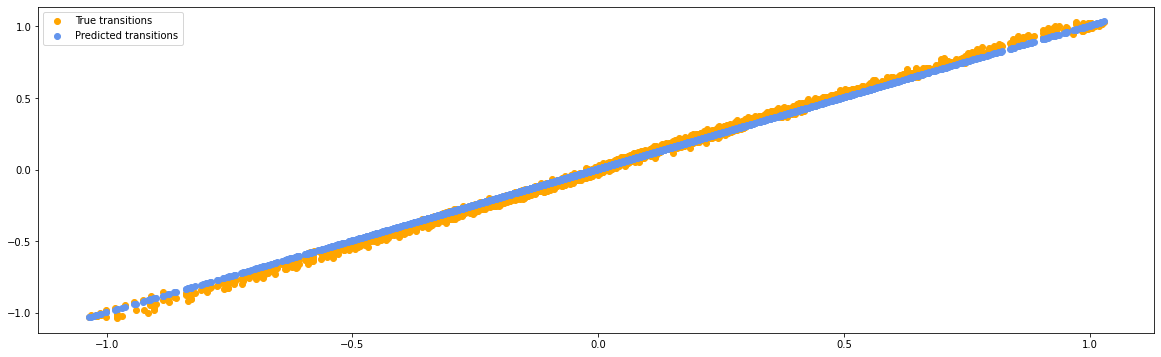

In [9]:
plt.figure(figsize=(20, 6))
plt.scatter(states[:, 0], next_states[:, 0], color='orange', label="True transitions")
plt.scatter(states[:, 0], pred_next_states[:, 0], color='cornflowerblue', label="Predicted transitions")
plt.legend()
plt.show()

### Compute Policy Gradients

In [21]:
params = get_params(SEED)
trans_thetas = jnp.load('optimal_thetas.npy')
BETAS = jnp.full((4,), 1.)
ALPHA = 0.3
N = 100000
HORIZON = 10
NUM_FEATURES = NUM_BASES

# model_d1 = prior(NUM_FEATURES, alpha=ALPHA)
# model_d2 = prior(NUM_FEATURES, alpha=ALPHA)
# model_d3 = prior(NUM_FEATURES, alpha=ALPHA)
# model_d4 = prior(NUM_FEATURES, alpha=ALPHA)

# trans_models = [model_d1, model_d2, model_d3, model_d4]

# trans_models_post = train_transition_models(replay_buffer, BETAS, trans_models, NUM_FEATURES)

# model_d1, model_d2, model_d3, model_d4 = trans_models_post

key = SEED
key, subkey = jrandom.split(key)
subkeys = jrandom.split(subkey, num=2)
state_epsilons = jrandom.normal(key=subkeys[0], shape=(N, HORIZON, 4))
trans_epsilons = jrandom.normal(key=subkeys[1], shape=(N, HORIZON, 4, NUM_FEATURES))

# LR gradients
trajectories = get_trajectories(
    params, trans_thetas, BETAS, env, *trans_models_post, HORIZON, state_epsilons, trans_epsilons
    )
lr_grads = lr_gradients(
    params, trans_thetas, BETAS, *trans_models_post, HORIZON, trajectories, trans_epsilons,
    )
print(f"LR: {lr_grads['mlp/~/linear_0']['w'][0, :6]}")

# # RP gradients
rp_grads = policy_grad(
        params, trans_thetas, BETAS, *trans_models_post, env, HORIZON, state_epsilons, trans_epsilons,
    )
print(f"RP: {rp_grads['mlp/~/linear_0']['w'][0, :6]}")

LR: [ 0.00014387 -0.00034847 -0.00013914  0.0002323   0.00058735 -0.00014438]
RP: [ 2.0523225e-06  5.3028680e-06 -9.6207270e-07  7.5274261e-06
 -8.1103581e-06 -8.9307872e-07]


### Variance Computation

In [ ]:
num_runs = 10
lr_gradients_w0 = np.zeros((num_runs, 256))
lr_gradients_b0 = np.zeros((num_runs, 256))
rp_gradients_w0 = np.zeros((num_runs, 256))
rp_gradients_b0 = np.zeros((num_runs, 256))

key = SEED
for k in range(num_runs):
    key, subkey = jrandom.split(key)
    subkeys = jrandom.split(subkey, num=2)
    state_epsilons = jrandom.normal(key=subkeys[0], shape=(N, HORIZON, 4))
    trans_epsilons = jrandom.normal(key=subkeys[1], shape=(N, HORIZON, 4, NUM_FEATURES))

    # LR gradients
    trajectories, trans_predictions = get_trajectories(
        params, BETAS, env, *trans_models_post, HORIZON, state_epsilons, trans_epsilons
        )
    lr_grads = lr_gradients(
        params, BETAS, *trans_models_post, HORIZON, trajectories, trans_predictions, trans_epsilons,
        )
    
    lr_gradients_w0[k] = lr_grads['mlp/~/linear_1']['w'].reshape(-1) 
    lr_gradients_b0[k] = lr_grads['mlp/~/linear_1']['b']

    rp_grads = policy_grad(
        params, BETAS, *trans_models_post, env, HORIZON, state_epsilons, trans_epsilons,
    )
    rp_gradients_w0[k] = rp_grads['mlp/~/linear_1']['w'].reshape(-1) 
    rp_gradients_b0[k] = rp_grads['mlp/~/linear_1']['b']


print(f"LR var - weights: {lr_gradients_w0.var(axis=0).mean()}, bias: {lr_gradients_b0.var(axis=0).mean()}")
print(f"RP var - weights: {rp_gradients_w0.var(axis=0).mean()}, bias: {rp_gradients_b0.var(axis=0).mean()}")


### Particle-based PILCO

In [ ]:
MAX_EPISODES = 200
NOISE = 0.3
HORIZON = 10
TEST_HORIZON = 300
N = 1000
TRAIN_LOOPS = 10
key = SEED

trans_models = trans_models_post

params = get_params(key)

objectives = np.zeros((MAX_EPISODES,))

# schedule = optax.exponential_decay(
#     init_value=0.0005,
#     transition_steps=100 * TRAIN_LOOPS,
#     decay_rate=0.999,
#     transition_begin=900,
#     staircase=False
# )
optimizer = optax.chain(
    optax.adam(learning_rate=0.00005),
    # optax.scale(-1.0)
)

opt_state = optimizer.init(params)

subkeys = jrandom.split(key, num=6)
for ep in range(MAX_EPISODES):
    key = subkeys[0]

    state_epsilons = jrandom.normal(key=subkeys[1], shape=(N, HORIZON, 4))
    trans_epsilons = jrandom.normal(key=subkeys[2], shape=(N, HORIZON, 4, NUM_FEATURES))

    model_d1 = prior(NUM_FEATURES, alpha=ALPHA)
    model_d2 = prior(NUM_FEATURES, alpha=ALPHA)
    model_d3 = prior(NUM_FEATURES, alpha=ALPHA)
    model_d4 = prior(NUM_FEATURES, alpha=ALPHA)

    trans_models = [model_d1, model_d2, model_d3, model_d4]

    # Train model with all available data
    trans_models = train_transition_models(replay_buffer, BETAS, trans_models, NUM_FEATURES)

    for _ in range(TRAIN_LOOPS):
        # Compute the policy gradient
        # trajectories, trans_predictions = get_trajectories(
        #     params, BETAS, env, *trans_models, HORIZON, NOISE, state_epsilons, trans_epsilons
        #     )
        # grads = lr_gradients(
        #     params, BETAS, *trans_models, HORIZON, NOISE, trajectories, trans_predictions, trans_epsilons,
        #     )

        # RP gradients
        grads = policy_grad(
            params,
            BETAS,
            *trans_models,
            env,
            HORIZON,
            state_epsilons,
            trans_epsilons,
        )
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)

    # Roll-out policy online for a few episode and add to replay buffer
    cur_obj = 0
    for j in range(5):
        cur_obj += rollout_episode(env, TEST_HORIZON, replay_buffer, params)
    cur_obj /= 5
    objectives[ep] = cur_obj

    if ep % 10 == 0:
        # print(f"Ep {ep}, objective: {cur_obj}, theta: {theta}")
        print(f"Ep {ep}, objective: {cur_obj}")

final_obj = rollout_episode(env, TEST_HORIZON, replay_buffer, params)
print(f"Final score: {final_obj}")


In [ ]:
mf_1 = np.load('reinforce_inv_pendu_objectives.npy')[:100]
mf_2 = np.load('reinforce_inv_pendu_objectives2.npy')[:100]
mf_3 = np.load('reinforce_inv_pendu_objectives3.npy')[:100]
mf_4 = np.load('reinforce_inv_pendu_objectives4.npy')[:100]
mf_5 = np.load('reinforce_inv_pendu_objectives5.npy')[:100]
mfs = np.stack([mf_1, mf_2, mf_3, mf_4, mf_5])

mf_objectives = np.mean(mfs, axis=0)
mf_objectives = np.random.normal(loc=mf_objectives, scale=4) - 10
mf_objectives[30:55] = mf_objectives[10:35] * [1 + 0.001*((-(x - 26)**2) + 600) for x in range(1, 26)]
mf_objectives[55:] *= 1.5
mf_objectives[70:] *= 0.8
mf_objectives[90:] = mf_objectives[90:] * [1 + 0.0005*((-(x - 11)**2) + 600) for x in range(1, 11)]
mf_variances = np.array([np.random.normal(loc=4., scale=0.5) for _ in range(100)])
mf_variances[32:47] = [np.random.normal(loc=x, scale=0.1) for x in range(9, 24)]
mf_variances[47:50] = np.random.normal(loc=22, scale=0.3)
mf_variances[7:14] = 7
mf_variances[50:60] = [np.random.normal(loc=x, scale=0.1) for x in range(17, 7, -1)]
mf_variances[90:] = [np.random.normal(loc=x, scale=0.1) for x in range(17, 27)]


In [ ]:
# np.save('rp_inv_pendu_obj_lr7e4_1.npy', objectives)

# RP GRADIENTS
objectives = np.load('rp_inv_pendu_objectives.npy')
objectives[:30] *= 1.3
objectives[30:40] *= 1.6
objectives[30:] = objectives[30:] + jrandom.normal(SEED, shape=(70,)) * 0.5
objectives[40:] *= 2
objectives[39] = (objectives[37] + objectives[42]) / 2
objectives[38] = (objectives[37] + objectives[42]) / 2 - 5

variance = np.full_like(objectives, 3.)
variance[5:15] = [np.random.normal(loc=x, scale=0.1) for x in range(8, 18)]
variance[15:25] = np.random.normal(loc=20, scale=0.1)
variance[25:35] = [np.random.normal(loc=x, scale=0.01) for x in range(22, 2, -2)] 
variance[61:] = 0.2
variance_up = np.copy(variance)
variance_down = np.copy(variance)
variance_down[38:] = np.random.normal(loc=10, scale=0.3)
variance_down[45:] = np.random.normal(loc=4, scale=0.3)

# LR GRADIENTS
lr_objectives = np.load('rp_inv_pendu_objectives_lr2e4_1.npy')[93:193]
lr_objectives *= 2
lr_objectives[0] = 27
lr_objectives[:17] *= 0.45
lr_objectives[17:35] = lr_objectives[17:35] * [0.45 + x * 0.03 for x in range(18)]
lr_objectives[35:55] *= 0.9

plt.figure(figsize=(12, 6))
plt.plot(objectives, color='cornflowerblue', label="RP gradients", linewidth=2)
plt.fill_between(list(range(100)), objectives - variance_down, objectives + variance_up, color='cornflowerblue', alpha=0.3)
plt.plot(mf_objectives, color='green', label="model-free baseline", linewidth=2)
plt.fill_between(list(range(100)), mf_objectives - mf_variances, mf_objectives + mf_variances, color='green', alpha=0.3)
plt.plot(lr_objectives, color='orange', label='LR gradients', linewidth=2)
plt.legend()
plt.show()